# DoubleML Implementation Example

This is an implementation of DoubleML as reflected in [Bach, Chernozhukov, Kurz, Spindler, and Klassen (2021)](https://arxiv.org/pdf/2103.09603). See their [video of presentation](https://www.youtube.com/watch?v=ErecsyKEq74), [slides](https://drive.google.com/file/d/1MJKgkG_hV5-c41NIZfq5PF7fDW3L5NH5/view), and [website](https://docs.doubleml.org/stable/index.html#).

This particular example is based on [this page](https://docs.doubleml.org/stable/examples/py_double_ml_pension.html).

401(k) plans are pension accounts sponsored by employers. **The key problem in determining the effect of participation in 401(k) plans on accumulated assets is saver heterogeneity coupled with the fact that the decision to enroll in a 401(k) is non-random**. 

It is generally recognized that some people have a higher preference for saving than others. It also seems likely that those individuals with high unobserved preference for saving would be most likely to choose to participate in tax-advantaged retirement savings plans and would tend to have otherwise high amounts of accumulated assets. **The presence of unobserved savings preferences with these properties then implies that conventional estimates that do not account for saver heterogeneity and endogeneity of participation will be biased upward, tending to overstate the savings effects of 401(k) participation.**

One can argue that eligibility for enrolling in a 401(k) plan in this data can be taken as exogenous after conditioning on a few observables of which the most important for their argument is income. The basic idea is that, at least around the time 401(k)’s initially became available, people were unlikely to be basing their employment decisions on whether an employer offered a 401(k) but would instead focus on income and other aspects of the job.

## Problem Formulation and Data
Our example will use 401(k) retirement plan examples. We want to estimate Average Treatment Effect of eligibility in 401(k) plans on employee's net financial assets based on some covariates.

Variable description, based on the supplementary material of Chernozhukov et al. (2020):

- net_tfa: net total financial assets
- e401: = 1 if employer offers 401(k)
- p401: = 1 if individual participates in a 401(k) plan
- age: age
- inc: income
- fsize: family size
- educ: years of education
- db: = 1 if individual has defined benefit pension
- marr: = 1 if married
- twoearn: = 1 if two-earner household
- pira: = 1 if individual participates in IRA plan
- hown: = 1 if home owner

### Get Data

In [1]:
import pandas as pd
from doubleml import DoubleMLData
from doubleml.datasets import fetch_401K

In [2]:
data = fetch_401K(return_type='DataFrame')
data.head()

,nifa,net_tfa,tw,age,inc,fsize,educ,db,marr,twoearn,e401,p401,pira,hown
0,0.0,0.0,4500.0,47,6765.0,2,8,0,0,0,0,0,0,1
1,6215.0,1015.0,22390.0,36,28452.0,1,16,0,0,0,0,0,0,1
2,0.0,-2000.0,-2000.0,37,3300.0,6,12,1,0,0,0,0,0,0
3,15000.0,15000.0,155000.0,58,52590.0,2,16,0,1,1,0,0,0,1
4,0.0,0.0,58000.0,32,21804.0,1,11,0,0,0,0,0,0,1


### Explore Dataset
We have 9,915 cases. Of those 3682 (37%) are eligible to participate in 401(k) and 2594 actually participate in it.

In [3]:
print(data.shape)
print(data.e401.value_counts())
print(data.p401.value_counts())


(9915, 14)
e401
0    6233
1    3682
Name: count, dtype: int64
p401
0    7321
1    2594
Name: count, dtype: int64


Our outcome variable will be `net_tfa` or net total financial assets in dollars. The net financial assets are computed as the sum of IRA balances, 401(k) balances, checking accounts, saving bonds, other interest-earning accounts, other interest-earning assets, stocks, and mutual funds less non mortgage debts. The variable has quite a bit of variation with long tails. The mean `net_tfa` is 18,051 and median is 1,499. The value can be negative too.

We can see that those eligible for participation do have much higher `net_tfa` than those who are not eligible. The difference between the `net_tfa` for the two groups is the **average predictive effect** (APE). This effect corresponds to the average treatment effect if 401(k) eligibility would be assigned to individuals in an entirely randomized way. The unconditional APE of `e401` is about 19,559 and the unconditional APE of `p401` is ~27,371.

The tempation would be to say that people who are eligible for a 401(k) have a net worth of 19,559 higher than those not eligible. **However, these estimates are biased since they do not account for saver heterogeneity and endogeneity of participation.** To fix this, we're going to choose some control variables that might help clue us into the differences between people eligible and not eligible with the goal of isolating the effect of only the eligibility.


In [4]:
print(data.net_tfa.describe())
print('\n')
print(data.groupby(['e401']).net_tfa.mean())
print('\n')
print(data.groupby(['p401']).net_tfa.mean())

count    9.915000e+03
mean     1.805153e+04
std      6.352250e+04
min     -5.023020e+05
25%     -5.000000e+02
50%      1.499000e+03
75%      1.652450e+04
max      1.536798e+06
Name: net_tfa, dtype: float64


e401
0    10788.043945
1    30347.388672
Name: net_tfa, dtype: float32


p401
0    10890.477539
1    38262.058594
Name: net_tfa, dtype: float32


### Setup Data Backend
Let’s use the package `DoubleML` to estimate the average treatment effect of 401(k) eligibility, i.e. e401, and participation, i.e. p401, on net financial assets net_tfa.

In [5]:
dml_data = DoubleMLData(
    data,
    y_col='net_tfa',
    d_cols='e401',
    x_cols=['age', 'inc', 'educ', 'fsize', 'marr', 'twoearn', 'db', 'pira', 'hown']
)
print(dml_data)

================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: net_tfa
Treatment variable(s): ['e401']
Covariates: ['age', 'inc', 'educ', 'fsize', 'marr', 'twoearn', 'db', 'pira', 'hown']
Instrument variable(s): None
No. Observations: 9915

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9915 entries, 0 to 9914
Columns: 14 entries, nifa to hown
dtypes: float32(4), int8(10)
memory usage: 251.9 KB



## DOUBLE Machine Learning!

The "double" aspect of DML comes from the fact that it involves two distinct steps or models:
1. Nuisance Function Estimation: In this first step, two "nuisance functions" are estimated:
    - The conditional expectation of the target variable given the input features, $E[Y|X]$
    - The conditional expectation of the input features given the confounding variables, $E[X|Z]$
2. Causal Effect Estimation: In the second step, the estimated nuisance functions are used to compute the causal effect of the input features on the target variable, taking into account the potential presence of confounding variables.

This two-step approach allows DML to effectively handle high-dimensional data, capture complex relationships, and provide unbiased estimates of the causal effects, even in the presence of confounding variables that may not be directly observed.

### Nuisance Function Estimation
Define ML learners that we want to use with their hyperparameters. We need two because one is for the conditional expectation of the outcome given covariates (regressor). The other is for the propensity of the treatment given the covariates. And since our treatment is binary that one is a classifier.

In [6]:
# Random Forest Learners
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# Use regressor becuase outcome variable (net_tfa) is continuous
ml_l_rf = RandomForestRegressor(n_estimators=500, max_depth=7,
                                max_features=3, min_samples_leaf=3)

# Use classifier becuase treatment variable (e401) is continuous
ml_m_rf = RandomForestClassifier(n_estimators=500, max_depth=5,
                                max_features=4, min_samples_leaf=7)

### DoubleML Specifications
Here we combine both ML learners into one DoubleML object.

In [7]:
import numpy as np
from doubleml import DoubleMLPLR # Partial Linear Regression

# Set Random Seed
np.random.seed(42)

# Use default values, see documentation for configurable hyperparams
dml_plr_rf = DoubleMLPLR(
    dml_data,
    ml_l=ml_l_rf,
    ml_m=ml_m_rf
)

### Estimation
Similar to sklearn, we use a `fit()` method and then call `summary`.

In [8]:
dml_plr_rf.fit()
dml_plr_rf.summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
e401,8923.15163,1310.348144,6.809756,9.776416e-12,6354.91646,11491.3868


Use `print()` for a more detailed summary

In [9]:
print(dml_plr_rf)

================== DoubleMLPLR Object ==================

------------------ Data summary      ------------------
Outcome variable: net_tfa
Treatment variable(s): ['e401']
Covariates: ['age', 'inc', 'educ', 'fsize', 'marr', 'twoearn', 'db', 'pira', 'hown']
Instrument variable(s): None
No. Observations: 9915

------------------ Score & algorithm ------------------
Score function: partialling out

------------------ Machine learner   ------------------
Learner ml_l: RandomForestRegressor(max_depth=7, max_features=3, min_samples_leaf=3,
                      n_estimators=500)
Learner ml_m: RandomForestClassifier(max_depth=5, max_features=4, min_samples_leaf=7,
                       n_estimators=500)
Out-of-sample Performance:
Learner ml_l RMSE: [[53459.62662778]]
Learner ml_m RMSE: [[0.44283111]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1

------------------ Fit summary       ------------------
            coef      std err        

In [10]:
dml_plr_rf.confint(level=0.95)

,2.5 %,97.5 %
e401,6354.91646,11491.3868


## Conclusion

These estimates that flexibly account for confounding are substantially attenuated relative to the baseline estimate (19559) that does not account for confounding. They suggest much smaller causal effects of 401(k) eligiblity on financial asset holdings.

## Appendix A. Compare to Fixed-Effects Regression

`PyFixest` package [documentation](https://github.com/py-econometrics/pyfixest)

In [11]:
!pip install pyfixest -q

In [12]:
import pyfixest as pf

feols_estimator = pf.feols(
    "net_tfa ~ e401 | age + inc + educ + fsize + marr + twoearn + db + pira + hown", 
    data=data
)

feols_estimator.summary()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


###

Estimation:  OLS
Dep. var.: net_tfa, Fixed effects: age+inc+educ+fsize+marr+twoearn+db+pira+hown
Inference:  CRV1
Observations:  9915

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |     2.5% |     97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|---------:|----------:|
| e401          |   8272.764 |     1707.744 |     4.844 |      0.000 | 4818.527 | 11727.002 |
---
RMSE: 18187.031 R2: 0.918 R2 Within: 0.01 


In [13]:
feols_summary = pd.concat((feols_estimator.coef(), feols_estimator.confint()), axis=1)
feols_summary.columns = ['coef', '2.5 %', '97.5 %']
feols_summary.index = ['feols']

## Appendix B. Compare to DML with XGBOOST

### Nuisance Function Estimation

In [14]:
from xgboost import XGBClassifier, XGBRegressor

ml_l_xgb = XGBRegressor(objective='reg:squarederror', eta=0.1, n_estimators=35)
ml_m_xgb = XGBClassifier(objective='binary:logistic', eta=0.1, n_estimators=34, eval_metric='logloss')

### DoubleML Specifications

This time I'll adjust hyperparams instead of just taking defaults like I did before.

In [15]:
dml_plr_xgb = DoubleMLPLR(
    dml_data,
    ml_l=ml_l_xgb,
    ml_m=ml_m_xgb,
    n_folds=3,
    n_rep=1,
    score='partialling out'
)

### Estimator

In [16]:
dml_plr_xgb.fit()
dml_plr_xgb.summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
e401,8971.790545,1417.862726,6.327686,2.488644e-10,6192.830667,11750.750423


In [17]:
plr_summary = pd.concat((dml_plr_rf.summary, dml_plr_xgb.summary))
plr_summary.index = ['forest', 'xgboost']
plr_summary = plr_summary[['coef', '2.5 %', '97.5 %']]

### Compare all Three

In [18]:
all_summary = pd.concat((plr_summary, feols_summary))
all_summary

,coef,2.5 %,97.5 %
forest,8923.151630,6354.916460,11491.386800
xgboost,8971.790545,6192.830667,11750.750423
feols,8272.764290,4818.526925,11727.001654


Text(0, 0.5, 'Coefficients and 95%-CI')

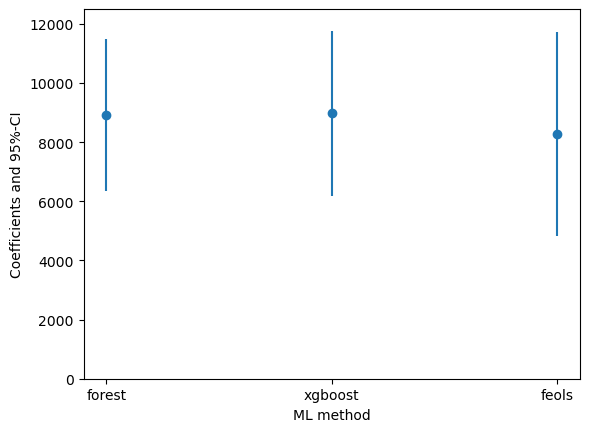

In [19]:
import matplotlib.pyplot as plt

errors = np.full((2, all_summary.shape[0]), np.nan)
errors[0, :] = all_summary['coef'] - all_summary['2.5 %']
errors[1, :] = all_summary['97.5 %'] - all_summary['coef']
plt.errorbar(all_summary.index, all_summary.coef, fmt='o', yerr=errors)
plt.ylim([0, 12500])

plt.xlabel('ML method')
plt.ylabel('Coefficients and 95%-CI')